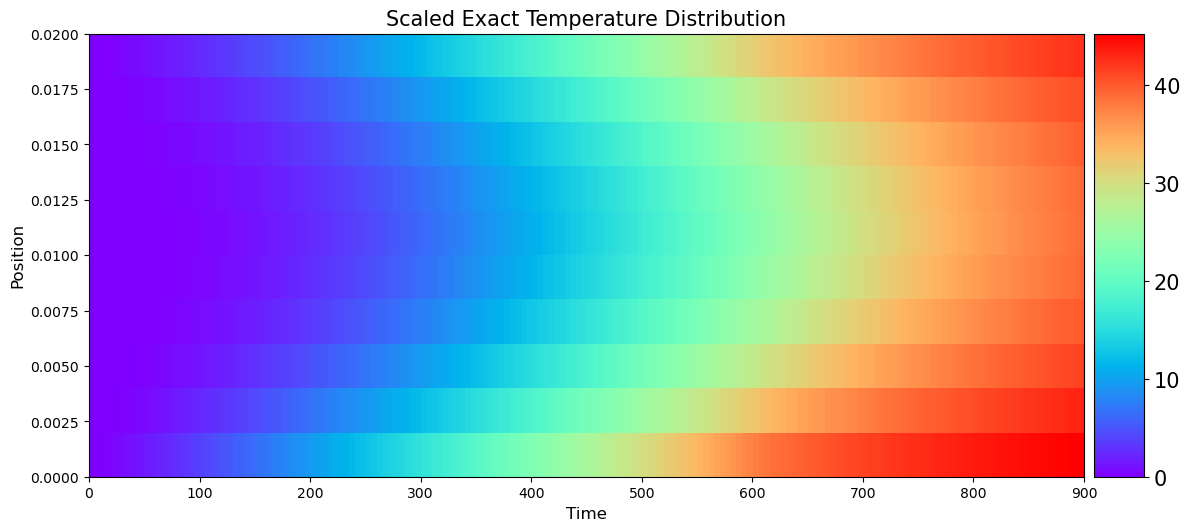

In [4]:
#epoch数2000でもいい感じの結果が出た
#初期条件付近でのサンプリング数をN_f // 5にして増やした
import sys
sys.path.insert(0, './Utilities/')

import torch
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

np.random.seed(1234)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

K = 0.47
rho = 1573
cp = 967
alpha = K / (rho * cp)
h1 = 100
h2 = 50
lambda_f, lambda_BC0, lambda_BC1, lambda_BC2 = 1.0, 1.0, 1.0, 1.0
N_u = 200
N_f = 10000
layers = [2, 50, 50, 50, 50, 50, 50, 50, 50, 1]

x = np.linspace(0, 0.02, 10)[:, None]
t = np.linspace(0, 900, 180)[:, None]

# メッシュグリッドの作成
X, T = np.meshgrid(x, t)

dx = x[1] - x[0]
dt = t[1] - t[0]

Nx = len(x)
Nt = len(t)
u = np.zeros((Nt, Nx))

# 正しい解の計算
for n in range(0, Nt - 1):
    if t[n] <= 600:
        T_ext1 = T_ext2 = 0 + (50 - 0) * t[n] / 600
    else:
        T_ext1 = T_ext2 = 50
    for i in range(1, Nx - 1):
        u[n + 1, i] = u[n, i] + alpha * dt * (u[n, i - 1] - 2 * u[n, i] + u[n, i + 1]) / dx**2

    u[n + 1, 0] = (4 * u[n + 1, 1] - u[n + 1, 2] + 2 * dx * h1 / K * T_ext1) / (3 + 2 * dx * h1 / K)
    u[n + 1, -1] = (4 * u[n + 1, -2] - u[n + 1, -3] + 2 * dx * h2 / K * T_ext2) / (3 + 2 * dx * h2 / K)

# X_star, u_starの作成
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = u.flatten()[:, None]

# スケーリング関数
def scale_x(x):
    return 2.0 * (x - lb[0]) / (ub[0] - lb[0]) - 1.0
def scale_t(t):
    return (t - lb[1]) / (ub[1] - lb[1])
def unscale_x(x):
    return 0.5 * (x + 1.0) * (ub[0] - lb[0]) + lb[0]
def unscale_t(t):
    return t * (ub[1] - lb[1]) + lb[1]

# スケーリングの準備
lb = X_star.min(0) # lb: [0. 0.]
ub = X_star.max(0) # ub: [2.0e-02 9.0+02]

# xのスケーリング   
x_scaled = scale_x(x)
# tのスケーリング
t_scaled = scale_t(t)

# ==========================正しい温度分布============================
# fig = plt.figure(figsize=(12, 10))
# ax1 = fig.add_subplot(211)
# h_img1 = ax1.imshow(u.T, interpolation='nearest', cmap='rainbow', 
#                 extent=[t_scaled.min(), t_scaled.max(), x_scaled.min(), x_scaled.max()],
#                 origin='lower', aspect='auto')
# divider1 = make_axes_locatable(ax1)
# cax1 = divider1.append_axes("right", size="5%", pad=0.10)
# cbar1 = fig.colorbar(h_img1, cax=cax1)
# cbar1.ax.tick_params(labelsize=15)
# ax1.set_title('Scaled Exact Temperature Distribution', fontsize=15)
# ax1.set_xlabel('Time', fontsize=12)
# ax1.set_ylabel('Position', fontsize=12)
# plt.tight_layout()
# plt.show()
# ==========================正しい温度分布============================
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(211)
h_img1 = ax1.imshow(u.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()],
                origin='lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.10)
cbar1 = fig.colorbar(h_img1, cax=cax1)
cbar1.ax.tick_params(labelsize=15)
ax1.set_title('Scaled Exact Temperature Distribution', fontsize=15)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Position', fontsize=12)
plt.tight_layout()
plt.show()

(100, 180)


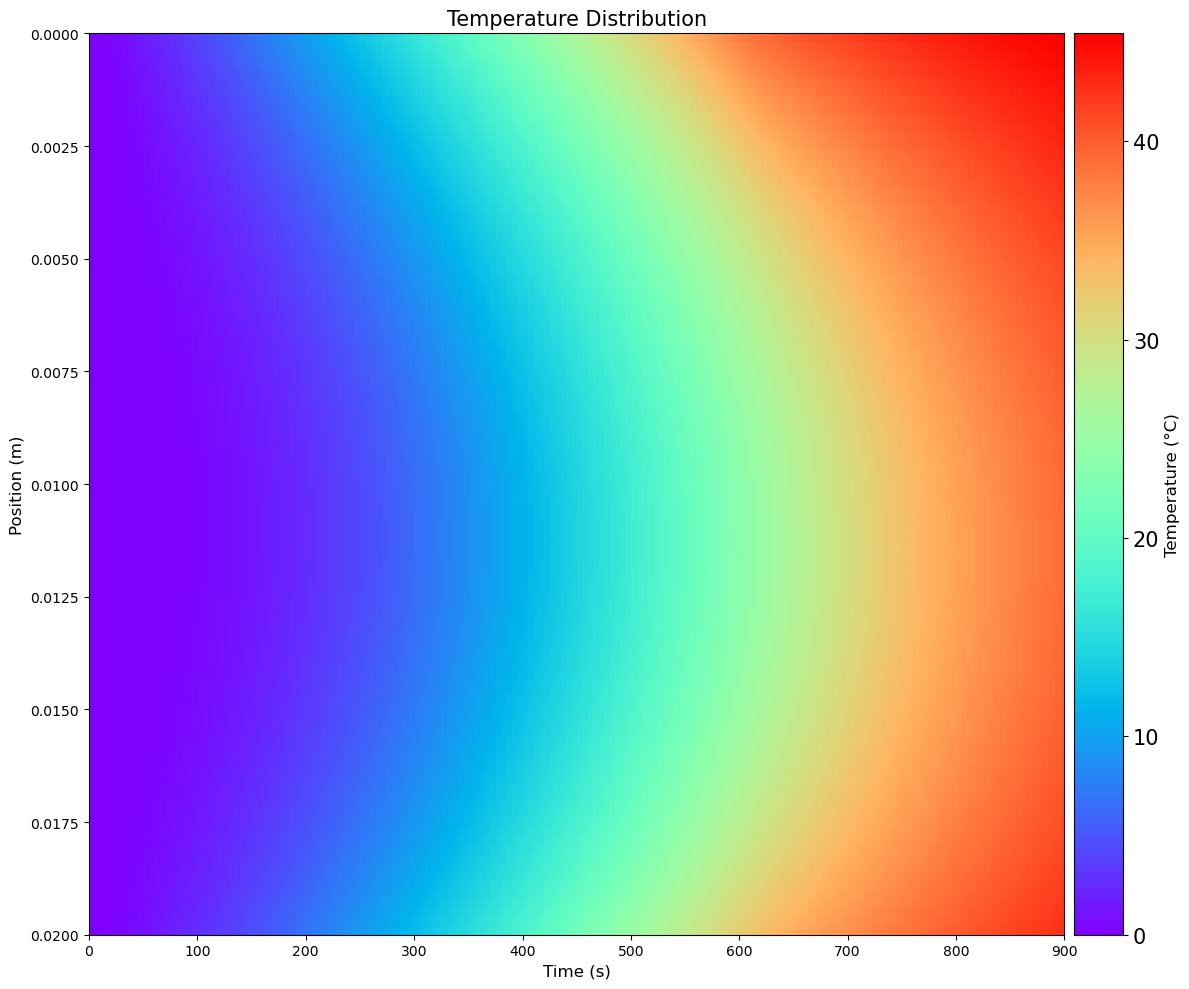

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.axes_grid1 import make_axes_locatable

# パラメータ
K = 0.47
rho = 1573
cp = 967
alpha = K / (rho * cp)
h1 = 100
h2 = 50
L = 0.02  # 材料の長さ
t_max = 900  # シミュレーション時間

# 境界条件
def T_ext(t):
    return 50 * min(t / 600, 1)

# PDEの右辺
def heat_equation(t, u):
    dudt = np.zeros_like(u)
    dx = L / (len(u) - 1)
    
    # 内部点
    dudt[1:-1] = alpha * (u[:-2] - 2*u[1:-1] + u[2:]) / dx**2
    
    # 左端（x=0）
    dudt[0] = (2*alpha/dx**2) * (u[1] - u[0]) + (2*h1/(rho*cp*dx)) * (T_ext(t) - u[0])
    
    # 右端（x=L）
    dudt[-1] = (2*alpha/dx**2) * (u[-2] - u[-1]) + (2*h2/(rho*cp*dx)) * (T_ext(t) - u[-1])
    
    return dudt

# 空間グリッドの設定
Nx = 100
x = np.linspace(0, L, Nx)

# 初期条件
u0 = np.zeros(Nx)

# 時間グリッドの設定
t_eval = np.linspace(0, t_max, 180)

# ODEソルバーの実行
sol = solve_ivp(heat_equation, [0, t_max], u0, t_eval=t_eval, method='RK45')

print(sol.y.shape)  # 形状の確認

# 結果の可視化
fig, ax = plt.subplots(figsize=(12, 10))
h_img = ax.imshow(sol.y, interpolation='nearest', cmap='rainbow', 
                  extent=[t_eval.min(), t_eval.max(), x.max(), x.min()],
                  aspect='auto', origin='upper')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h_img, cax=cax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Temperature (°C)', fontsize=12)
ax.set_title('Temperature Distribution', fontsize=15)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Position (m)', fontsize=12)
plt.tight_layout()
plt.show()